In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from tqdm import tqdm
import requests
import zipfile
from pathlib import Path
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cpu


In [98]:
import albumentations as A

augmentations = A.Compose([
    A.HorizontalFlip(p=0.9),
    A.Resize(256, 256),  # Resize to ensure uniform size
])


# List of directories containing paired input/target subdirectories
dataset_dirs = [r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_test50", 
                r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_train250",
                r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\Smartphone\unaligned150"               
                ]  # Add paths to your directories here

# Global output directories
output_input_dir = r"D:/MANIPAL/Research/Reflection_Removal/Code/new_aug/aug_blended"
output_target_dir = r"D:/MANIPAL/Research/Reflection_Removal/Code/new_aug/aug_transmission_layer"

# Ensure output directories exist
os.makedirs(output_input_dir, exist_ok=True)
os.makedirs(output_target_dir, exist_ok=True)

# Function to augment and save images
def augment_and_save(input_path, target_path, output_input_dir, output_target_dir, new_name):
    input_image = cv2.imread(input_path)
    target_image = cv2.imread(target_path)

    # Apply augmentations
    augmented = augmentations(image=input_image, mask=target_image)
    augmented_input = augmented['image']
    augmented_target = augmented['mask']

    # Save augmented images
    cv2.imwrite(os.path.join(output_input_dir, new_name), augmented_input)
    cv2.imwrite(os.path.join(output_target_dir, new_name), augmented_target)

# Process each dataset directory
image_counter = 0  # Counter to ensure unique filenames across all directories

for dataset_dir in dataset_dirs:
    input_dir = os.path.join(dataset_dir, "blended")
    target_dir = os.path.join(dataset_dir, "transmission_layer")

    # Process each pair of input/target images
    input_files = sorted(os.listdir(input_dir))
    target_files = sorted(os.listdir(target_dir))

    for input_file, target_file in zip(input_files, target_files):
        # Ensure input and target have the same name
        input_path = os.path.join(input_dir, input_file)
        target_path = os.path.join(target_dir, target_file)

        # Perform at least 5 augmentations per image
        for i in range(3):
            new_name = f"aug_image_{image_counter:04d}.jpg"  # Unique name with a zero-padded counter
            augment_and_save(input_path, target_path, output_input_dir, output_target_dir, new_name)
            image_counter += 1

print("Augmentation completed. All images are stored in 'aug_input' and 'aug_output'.")


Augmentation completed. All images are stored in 'aug_input' and 'aug_output'.


In [3]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

class ReflectionRemovalDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])

        input_image = Image.open(input_path).convert("RGB")
        output_image = Image.open(output_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset paths
input_dir = r"D:/MANIPAL/Research/Reflection_Removal/Code/reflection"
output_dir = r"D:/MANIPAL/Research/Reflection_Removal/Code/clear"

# Dataset and Dataloader
dataset = ReflectionRemovalDataset(input_dir, output_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out + residual

# Channel Attention
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y

# Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.sigmoid(self.conv(y))
        return x * y

# Combined Channel and Spatial Attention
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_attn = ChannelAttention(in_channels)
        self.spatial_attn = SpatialAttention()

    def forward(self, x):
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x

# Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]
        self.vgg = vgg.eval()  # Extract features
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.loss = nn.MSELoss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.loss(x_features, y_features)

# Reflection Removal Network
class ReflectionRemovalNet(nn.Module):
    def __init__(self):
        super(ReflectionRemovalNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            self.conv_block(512, 1024),
            CBAM(1024)  # Apply CBAM attention in bottleneck
        )

        # Decoder with Residual Blocks
        self.dec1 = self.deconv_block(1024 + 512, 512)
        self.dec2 = self.deconv_block(512 + 256, 256)
        self.dec3 = self.deconv_block(256 + 128, 128)
        self.dec4 = self.deconv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=3, padding=1)

        # Attention
        self.cbam = CBAM(64)

        # Sigmoid activation for output
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(out_channels)  # Replaced LeakyReLU with PReLU
        )

    def deconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(out_channels),
            ResidualBlock(out_channels)  # Add residual blocks to decoder
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))
        x4 = self.enc4(F.max_pool2d(x3, 2))

        # Bottleneck
        x_bottleneck = self.bottleneck(F.max_pool2d(x4, 2))

        # Decoder with skip connections
        x5 = self.dec1(torch.cat([x4, F.interpolate(x_bottleneck, size=x4.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x6 = self.dec2(torch.cat([x3, F.interpolate(x5, size=x3.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x7 = self.dec3(torch.cat([x2, F.interpolate(x6, size=x2.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x8 = self.dec4(torch.cat([x1, F.interpolate(x7, size=x1.shape[2:], mode="bilinear", align_corners=False)], dim=1))

        # Final CBAM attention and output
        x8 = self.cbam(x8)
        output = self.sigmoid(self.final(x8))
        return F.interpolate(output, size=x.shape[2:], mode="bilinear", align_corners=False)


Epoch [1/50], Loss: 0.0684
Epoch [2/50], Loss: 0.0620
Epoch [3/50], Loss: 0.0570
Epoch [4/50], Loss: 0.0524
Epoch [5/50], Loss: 0.0480
Epoch [6/50], Loss: 0.0441
Epoch [7/50], Loss: 0.0405
Epoch [8/50], Loss: 0.0373
Epoch [9/50], Loss: 0.0344
Epoch [10/50], Loss: 0.0317
Epoch [11/50], Loss: 0.0293
Epoch [12/50], Loss: 0.0271
Epoch [13/50], Loss: 0.0251
Epoch [14/50], Loss: 0.0233
Epoch [15/50], Loss: 0.0217
Epoch [16/50], Loss: 0.0203
Epoch [17/50], Loss: 0.0190
Epoch [18/50], Loss: 0.0178
Epoch [19/50], Loss: 0.0167
Epoch [20/50], Loss: 0.0157
Epoch [21/50], Loss: 0.0148
Epoch [22/50], Loss: 0.0140
Epoch [23/50], Loss: 0.0133
Epoch [24/50], Loss: 0.0126
Epoch [25/50], Loss: 0.0120
Epoch [26/50], Loss: 0.0114
Epoch [27/50], Loss: 0.0109
Epoch [28/50], Loss: 0.0104
Epoch [29/50], Loss: 0.0100
Epoch [30/50], Loss: 0.0096
Epoch [31/50], Loss: 0.0092
Epoch [32/50], Loss: 0.0088
Epoch [33/50], Loss: 0.0085
Epoch [34/50], Loss: 0.0082
Epoch [35/50], Loss: 0.0079
Epoch [36/50], Loss: 0.0077
E

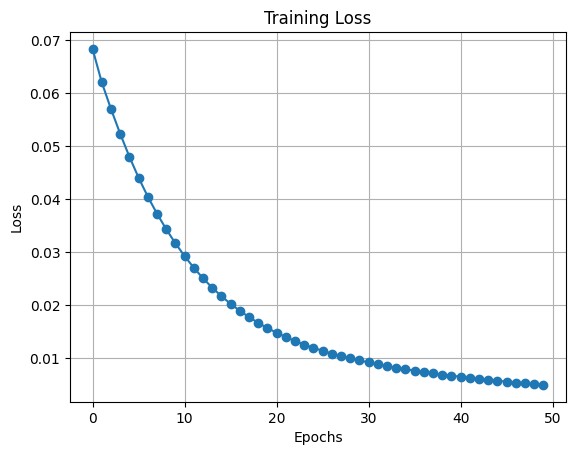

Model saved at D:\MANIPAL\Research\Reflection_Removal\Code\final_model.pth


In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Loss (MSELoss), and Optimizer
model = ReflectionRemovalNet().to(device)
criterion = nn.MSELoss().to(device)  # Using Mean Squared Error Loss instead of Perceptual Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Configuration
num_epochs = 50
loss_history = []  # Track average loss for each epoch

# Training Loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Track loss for the epoch

    # Assuming 'dataloader' is defined elsewhere and provides reflected and clean images
    for reflected, clean in dataloader:
        reflected, clean = reflected.to(device), clean.to(device)

        # Forward Pass
        optimizer.zero_grad()
        output = model(reflected)  # Get the final output (x8)
        
        # Calculate MSE Loss
        loss = criterion(output, clean)

        # Backward Pass and Optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average Loss for the Epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Plot Training Loss
plt.plot(loss_history, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

# Save the Trained Model
model_save_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\final_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")


C:\Users\chris\AppData\Local\Temp\ipykernel_19236\4017060693.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

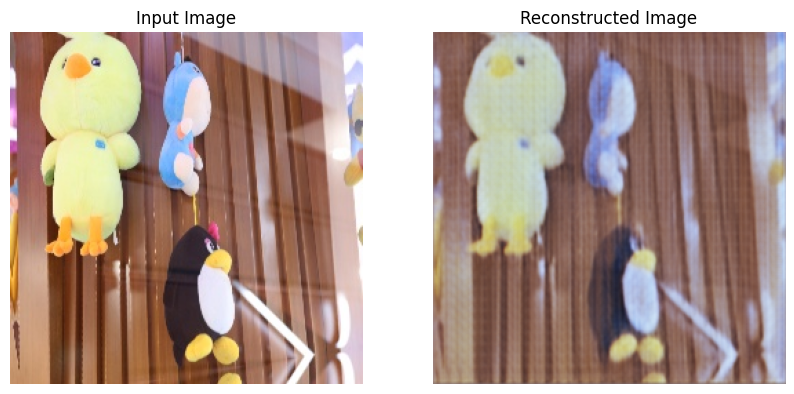

In [23]:
import cv2
def test_model(model_path, test_image_path):
    # Load the model
    model = ReflectionRemovalNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load and preprocess test image
    input_image = Image.open(test_image_path).convert("RGB")
    original_size = input_image.size  # Save original dimensions (width, height)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Post-process the output tensor
    output_tensor = output_tensor.squeeze(0).cpu().numpy()
    output_image = np.transpose(output_tensor, (1, 2, 0))  # Convert to HxWxC format
    output_image = np.clip(output_image, 0, 1)  # Clamp values to [0, 1]

    # Resize the output image to match the original dimensions
    output_image = cv2.resize(output_image, original_size, interpolation=cv2.INTER_LINEAR)

    # Display the input and output images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Reconstructed Image")
    plt.axis("off")

    plt.show()

# Test the model
test_image_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\reflection\aug_image_0018.jpg"
test_model(r"D:\MANIPAL\Research\Reflection_Removal\Code\final_model.pth", test_image_path)


##GANS Implementation

In [41]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

class ReflectionRemovalDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])

        input_image = Image.open(input_path).convert("RGB")
        output_image = Image.open(output_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset paths
input_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\reflection"
output_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\clear"

# Dataset and Dataloader
dataset = ReflectionRemovalDataset(input_dir, output_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReflectionRemovalNet(nn.Module):
    def __init__(self):
        super(ReflectionRemovalNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # New Encoder Layer
        self.enc5 = self.conv_block(512, 1024)  # Added a new layer

        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048)  # Increased complexity in the bottleneck

        # Decoder
        self.dec1 = self.deconv_block(2048 + 1024, 1024)  # Increased channels in the decoder
        self.dec2 = self.deconv_block(1024 + 512, 512)
        self.dec3 = self.deconv_block(512 + 256, 256)
        self.dec4 = self.deconv_block(256 + 128, 128)
        self.final = nn.Conv2d(128, 3, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

        # Attention modules
        self.channel_attn = ChannelAttention(2048)  # Updated attention module to match increased complexity
        self.spatial_attn = SpatialAttention()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def deconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))
        x4 = self.enc4(F.max_pool2d(x3, 2))
        x5 = self.enc5(F.max_pool2d(x4, 2))  # Output of the new encoder layer

        # Bottleneck
        x_bottleneck = self.bottleneck(F.max_pool2d(x5, 2))  # Deeper bottleneck layer

        # Decoder
        x6 = self.dec1(torch.cat([x5, F.interpolate(x_bottleneck, size=x5.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x7 = self.dec2(torch.cat([x4, F.interpolate(x6, size=x4.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x8 = self.dec3(torch.cat([x3, F.interpolate(x7, size=x3.shape[2:], mode="bilinear", align_corners=False)], dim=1))
        x9 = self.dec4(torch.cat([x2, F.interpolate(x8, size=x2.shape[2:], mode="bilinear", align_corners=False)], dim=1))

        # Final output
        output = self.sigmoid(self.final(x9))
        return F.interpolate(output, size=x.shape[2:], mode="bilinear", align_corners=False)


# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.sigmoid(self.conv(y))
        return x * y

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # First Layer
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Second Layer
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third Layer
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth Layer
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Fifth Layer (Added)
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # New deeper layer
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            # Final Layer
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),  # Output layer
            nn.Sigmoid()  # Sigmoid activation to output probability
        )

    def forward(self, x):
        return self.model(x)

# Initialize Models
generator = ReflectionRemovalNet()
discriminator = Discriminator()

# from torchsummary import summary

# # Set the model to evaluation mode (if needed)
# generator.eval()
# discriminator.eval()

# # Print the summary for the ReflectionRemovalNet
# print("Reflection Removal Network Summary:")
# summary(generator, (3, 256, 256))  # Adjust input shape (3 channels, 256x256 image size)

# # Print the summary for the Discriminator
# print("\nDiscriminator Summary:")
# summary(discriminator, (3, 256, 256))  # Adjust input shape (3 channels, 256x256 image size)


C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Generator Loss: 30.0832, Discriminator Loss: 1.3189
Epoch [2/100], Generator Loss: 14.0216, Discriminator Loss: 0.0059
Epoch [3/100], Generator Loss: 17.2729, Discriminator Loss: 11.0520
Epoch [4/100], Generator Loss: 5.9260, Discriminator Loss: 6.2213
Epoch [5/100], Generator Loss: 8.7717, Discriminator Loss: 3.4147
Epoch [6/100], Generator Loss: 6.8419, Discriminator Loss: 0.2410
Epoch [7/100], Generator Loss: 8.5108, Discriminator Loss: 0.8752
Epoch [8/100], Generator Loss: 1.0333, Discriminator Loss: 3.3412
Epoch [9/100], Generator Loss: 6.6504, Discriminator Loss: 4.8727
Epoch [10/100], Generator Loss: 2.6026, Discriminator Loss: 1.3069
Epoch [11/100], Generator Loss: 4.3663, Discriminator Loss: 1.6950
Epoch [12/100], Generator Loss: 1.4010, Discriminator Loss: 1.9272
Epoch [13/100], Generator Loss: 4.9772, Discriminator Loss: 2.7246
Epoch [14/100], Generator Loss: 1.4028, Discriminator Loss: 2.7217
Epoch [15/100], Generator Loss: 2.4469, Discriminator Loss: 2.1188


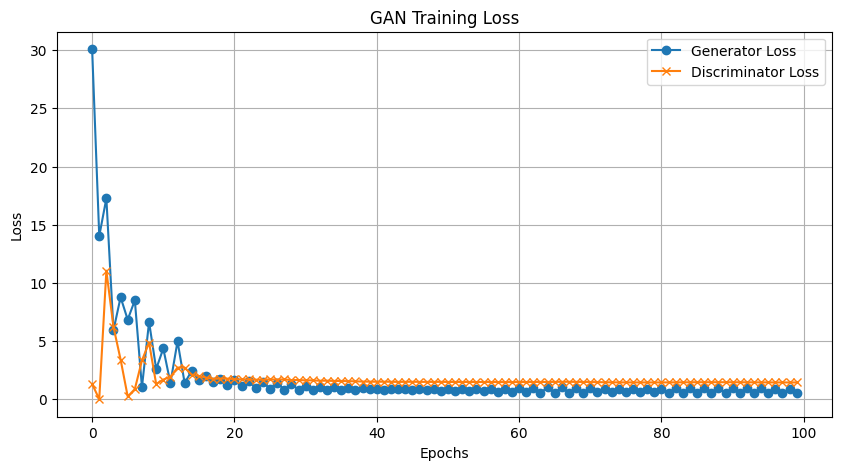

Generator model saved at D:\MANIPAL\Research\Reflection_Removal\Code\generator_final_model.pth


In [53]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import vgg19

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator (ReflectionRemovalNet) and Discriminator
generator = ReflectionRemovalNet().to(device)
discriminator = Discriminator().to(device)

# VGG Loss Class (Perceptual Loss)
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        # Load pretrained VGG19 model and use the first 36 layers for feature extraction
        vgg = vgg19(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(vgg)[:36]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze the VGG layers
        self.criterion = nn.MSELoss()  # Use MSE as the perceptual loss
        

    def forward(self, x, y):
        # Extract features using the pre-trained VGG model
        x_features = self.feature_extractor(x)
        y_features = self.feature_extractor(y)
        return self.criterion(x_features, y_features)

# Loss Functions
criterion_gan = nn.BCELoss().to(device)  # GAN loss
criterion_pixelwise = nn.MSELoss().to(device)  # Pixel-wise loss for reflection removal
vgg_loss = VGGLoss().to(device)  # VGG-based perceptual loss

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

# Training Configuration
num_epochs = 100
loss_history_g = []  # Track generator loss
loss_history_d = []  # Track discriminator loss

# Labels
real_label = 1.0
fake_label = 0.0

# Training Loop
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    epoch_loss_g, epoch_loss_d = 0, 0  # Track generator and discriminator loss for the epoch

    # Assuming 'dataloader' is defined elsewhere and provides reflected and clean images
    for reflected, clean in dataloader:
        reflected, clean = reflected.to(device), clean.to(device)

        ### Train Discriminator ###
        optimizer_d.zero_grad()

        # Real images
        real_output = discriminator(clean)
        real_labels = torch.full_like(real_output, real_label, device=device)
        d_loss_real = criterion_gan(real_output, real_labels)

        # Fake images
        fake_images = generator(reflected)
        fake_output = discriminator(fake_images.detach())  # Detach the generator to avoid backprop in the generator
        fake_labels = torch.full_like(fake_output, fake_label, device=device)
        d_loss_fake = criterion_gan(fake_output, fake_labels)

        # Total Discriminator Loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        ### Train Generator ###
        optimizer_g.zero_grad()

        # GAN Loss (Generator wants discriminator to predict "real")
        fake_output = discriminator(fake_images)
        gan_loss = criterion_gan(fake_output, real_labels)

        # Pixel-wise Loss (MSE)
        pixel_loss = criterion_pixelwise(fake_images, clean)

        # Perceptual Loss (VGG Loss)
        perceptual_loss = vgg_loss(fake_images, clean)

        # Total Generator Loss
        g_loss = gan_loss + 100 * pixel_loss + 0.01 * perceptual_loss  # Adjusted balance of losses
        g_loss.backward()
        optimizer_g.step()

        epoch_loss_g += g_loss.item()
        epoch_loss_d += d_loss.item()

    # Average Loss for the Epoch
    avg_loss_g = epoch_loss_g / len(dataloader)
    avg_loss_d = epoch_loss_d / len(dataloader)
    loss_history_g.append(avg_loss_g)
    loss_history_d.append(avg_loss_d)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Generator Loss: {avg_loss_g:.4f}, Discriminator Loss: {avg_loss_d:.4f}")

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history_g, label="Generator Loss", marker="o")
plt.plot(loss_history_d, label="Discriminator Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.grid()
plt.show()

# Save the Trained Generator
model_save_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\generator_final_model.pth"
torch.save(generator.state_dict(), model_save_path)
print(f"Generator model saved at {model_save_path}")


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sharpen_image(image):
    # Read the image
    # image = cv2.imread(image_path)
    
    # Convert to YUV color space
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    # Extract the Y (luminance) channel
    y_channel = yuv_image[:, :, 0]

    # Define a sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    # Apply the sharpening filter to the Y (luminance) channel
    y_sharpened = cv2.filter2D(y_channel, -1, kernel)

    # Replace the sharpened Y channel back in the YUV image
    yuv_image[:, :, 0] = y_sharpened

    # Convert back to RGB color space
    sharpened_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

    return sharpened_image

    
    # # Display original and sharpened images
    # plt.figure(figsize=(10,5))
    # plt.subplot(1, 2, 1)
    # plt.title("Original Image")
    # plt.imshow(image)
    # plt.axis("off")
    
    # plt.subplot(1, 2, 2)
    # plt.title("Sharpened Image")
    # plt.imshow(sharpened_image)
    # plt.axis("off")
    
    # plt.show()

# Example usage:
image_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_train250\blended\291.png"  # Replace with your image path
# sharpen_image(image_path)


C:\Users\chris\AppData\Local\Temp\ipykernel_23992\3525136585.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_lo

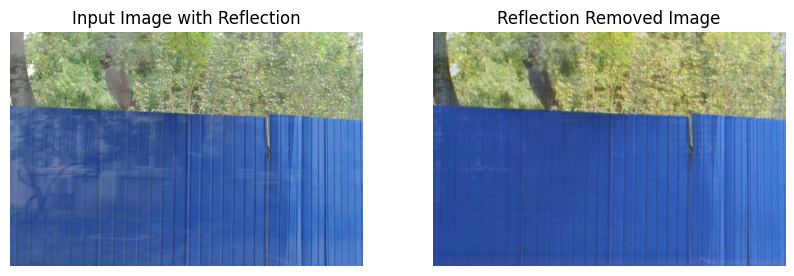

In [3]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_gan_model(generator_path, test_image_path):
    """
    Tests the GAN generator for reflection removal on a single image.
    
    Parameters:
        generator_path (str): Path to the saved generator model.
        test_image_path (str): Path to the test image.
    """
    # Load the generator model
    generator = ReflectionRemovalNet().to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    # Load and preprocess the test image
    input_image = Image.open(test_image_path).convert("RGB")
    original_size = input_image.size  # Save original dimensions (width, height)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output_tensor = generator(input_tensor)

    # Post-process the output tensor
    output_tensor = output_tensor.squeeze(0).cpu().numpy()
    output_image = np.transpose(output_tensor, (1, 2, 0))  # Convert to HxWxC format
    output_image = np.clip(output_image, 0, 1)  # Clamp values to [0, 1]

    # Resize the output image to match the original dimensions
    output_image = cv2.resize(output_image, original_size, interpolation=cv2.INTER_LINEAR)

    # Display the input and output images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(input_image))
    plt.title("Input Image with Reflection")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow((output_image)) 
    cv2.imwrite(r"D:\MANIPAL\Research\Reflection_Removal\Code\sharpened.jpg",output_image)
    plt.title("Reflection Removed Image")
    plt.axis("off")

    plt.show()
   
# Test the model
test_image_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\reflection\0.png"
generator_model_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\generator_final_model.pth"

test_gan_model(generator_model_path, test_image_path)


In [6]:
%pip install -U scikit-image

  Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached tifffile-2024.9.20-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl (12.9 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.9.20-py3-none-any.whl (228 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\Python312\\Scripts\\lsm2bin.exe' -> 'c:\\Python312\\Scripts\\lsm2bin.exe.deleteme'



C:\Users\chris\AppData\Local\Temp\ipykernel_23992\1832674565.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_l

Metrics:
PSNR: 20.0696
SSIM: 0.3892
Precision: 0.7730
Recall: 0.8636
Accuracy: 0.8977


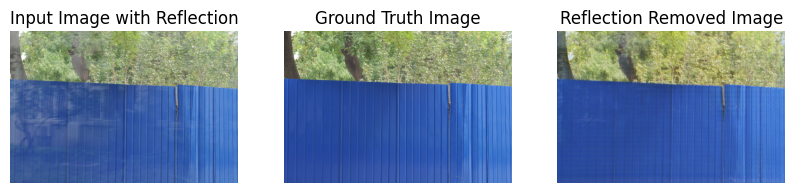

In [5]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def calculate_psnr(output_image, ground_truth_image):
    """
    Calculates PSNR between two images.

    Parameters:
        output_image (numpy.ndarray): The generated image (HxWxC).
        ground_truth_image (numpy.ndarray): The ground truth clean image (HxWxC).

    Returns:
        float: PSNR value.
    """
    mse = np.mean((ground_truth_image - output_image) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    max_pixel = 1.0  # Assuming normalized images
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def calculate_ssim(output_image, ground_truth_image):
    """
    Calculates SSIM (Structural Similarity Index) between two images.

    Parameters:
        output_image (numpy.ndarray): The generated image (HxWxC).
        ground_truth_image (numpy.ndarray): The ground truth clean image (HxWxC).

    Returns:
        float: SSIM value.
    """
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    # Convert to grayscale
    output_gray = cv2.cvtColor((output_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
    ground_truth_gray = cv2.cvtColor((ground_truth_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    # Mean and variance
    mu_x = cv2.GaussianBlur(output_gray, (11, 11), 1.5)
    mu_y = cv2.GaussianBlur(ground_truth_gray, (11, 11), 1.5)
    sigma_x = cv2.GaussianBlur(output_gray ** 2, (11, 11), 1.5) - mu_x ** 2
    sigma_y = cv2.GaussianBlur(ground_truth_gray ** 2, (11, 11), 1.5) - mu_y ** 2
    sigma_xy = cv2.GaussianBlur(output_gray * ground_truth_gray, (11, 11), 1.5) - mu_x * mu_y

    # SSIM calculation
    numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    ssim_map = numerator / (denominator + 1e-6)
    return ssim_map.mean()

def calculate_precision_recall_accuracy(output_image, ground_truth_image):
    """
    Calculates Precision, Recall, and Accuracy for binary images.

    Parameters:
        output_image (numpy.ndarray): The generated image (HxWxC).
        ground_truth_image (numpy.ndarray): The ground truth clean image (HxWxC).

    Returns:
        dict: Dictionary containing Precision, Recall, and Accuracy.
    """
    # Convert to grayscale
    output_gray = cv2.cvtColor((output_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    ground_truth_gray = cv2.cvtColor((ground_truth_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Binarize the images (thresholding)
    _, output_binary = cv2.threshold(output_gray, 128, 1, cv2.THRESH_BINARY)
    _, ground_truth_binary = cv2.threshold(ground_truth_gray, 128, 1, cv2.THRESH_BINARY)

    # Calculate TP, FP, FN, TN
    tp = np.sum(output_binary * ground_truth_binary)  # True Positives
    fp = np.sum(output_binary * (1 - ground_truth_binary))  # False Positives
    fn = np.sum((1 - output_binary) * ground_truth_binary)  # False Negatives
    tn = np.sum((1 - output_binary) * (1 - ground_truth_binary))  # True Negatives

    precision = tp / (tp + fp + 1e-6)  # Avoid division by zero
    recall = tp / (tp + fn + 1e-6)
    accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)

    return {"Precision": precision, "Recall": recall, "Accuracy": accuracy}

def test_gan_model(generator_path, test_image_path, ground_truth_path):
    """
    Tests the GAN generator for reflection removal on a single image and calculates metrics.

    Parameters:
        generator_path (str): Path to the saved generator model.
        test_image_path (str): Path to the test image.
        ground_truth_path (str): Path to the ground truth clean image.
    """
    # Load the generator model
    generator = ReflectionRemovalNet().to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    # Load and preprocess the test image
    input_image = Image.open(test_image_path).convert("RGB")
    original_size = input_image.size

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output_tensor = generator(input_tensor)

    # Post-process the output tensor
    output_tensor = output_tensor.squeeze(0).cpu().numpy()
    output_image = np.transpose(output_tensor, (1, 2, 0))
    output_image = np.clip(output_image, 0, 1)

    # Load ground truth image
    ground_truth_image = Image.open(ground_truth_path).convert("RGB")
    ground_truth_image = np.asarray(ground_truth_image).astype(np.float32) / 255.0

    # Resize the output image to match ground truth dimensions
    output_image = cv2.resize(output_image, (ground_truth_image.shape[1], ground_truth_image.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Calculate metrics
    psnr_value = calculate_psnr(output_image, ground_truth_image)
    ssim_value = calculate_ssim(output_image, ground_truth_image)
    metrics = calculate_precision_recall_accuracy(output_image, ground_truth_image)

    # Display metrics
    print("Metrics:")
    print(f"PSNR: {psnr_value:.4f}")
    print(f"SSIM: {ssim_value:.4f}")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Display the input and output images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(input_image))
    plt.title("Input Image with Reflection")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_image)
    plt.title("Ground Truth Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(output_image)
    plt.title("Reflection Removed Image")
    plt.axis("off")

    plt.show()

# Test the model
test_image_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_train250\blended\0.png"
ground_truth_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_train250\transmission_layer\0.png"
generator_model_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\generator_final_model.pth"

test_gan_model(generator_model_path, test_image_path, ground_truth_path)


From scratch

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# Reflection Removal Network with ResNet-style Encoder and Decoder
class ReflectionRemovalNet(nn.Module):
    def __init__(self):
        super(ReflectionRemovalNet, self).__init__()

        # Encoder with ResNet Blocks
        self.encoder = nn.Sequential(
            ResidualBlock(3, 64, stride=1),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            ResidualBlock(256, 256, stride=1)
        )
        
        # Decoder with ResNet Blocks
        self.decoder = nn.Sequential(
            ResidualBlock(256, 128, stride=1),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(128, 64, stride=1),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Normalize output to [0, 1]
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        bottleneck = self.bottleneck(enc)
        dec = self.decoder(bottleneck)
        return dec

# Perceptual Loss using VGG19
class PerceptualLoss(nn.Module):
    def __init__(self, vgg19_model_path=None):
        super(PerceptualLoss, self).__init__()
        if vgg19_model_path:
            vgg = torch.load(vgg19_model_path).features
        else:
            vgg = models.vgg19(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg[:16])).eval()  # Use layers up to relu4_1
        for param in self.layers.parameters():
            param.requires_grad = False  # Freeze VGG weights

    def forward(self, input, target):
        input_features = self.layers(input)
        target_features = self.layers(target)
        return nn.functional.l1_loss(input_features, target_features)

# Reconstruction Loss for Pixel-Level Accuracy
class ReconstructionLoss(nn.Module):
    def __init__(self, loss_type='l1'):
        """
        Initializes the reconstruction loss.
        Args:
            loss_type (str): Type of pixel-level loss ('l1' or 'l2').
        """
        super(ReconstructionLoss, self).__init__()
        if loss_type == 'l1':
            self.loss_fn = nn.L1Loss()
        elif loss_type == 'l2':
            self.loss_fn = nn.MSELoss()
        else:
            raise ValueError("loss_type must be 'l1' or 'l2'")

    def forward(self, predicted, target):
        """
        Computes the reconstruction loss.
        Args:
            predicted (Tensor): The reconstructed image from the model.
            target (Tensor): The ground truth target image.
        Returns:
            Tensor: Computed reconstruction loss.
        """
        return self.loss_fn(predicted, target)


In [16]:
import os
from PIL import Image
from torchvision import transforms

# Dataset for Reflection Removal
class ReflectionDataset(torch.utils.data.Dataset):
    def __init__(self, reflected_dir, clear_dir, transform=None):
        self.reflected_files = sorted(os.listdir(reflected_dir))
        self.clear_files = sorted(os.listdir(clear_dir))
        self.reflected_dir = reflected_dir
        self.clear_dir = clear_dir
        self.transform = transform

    def __len__(self):
        return len(self.reflected_files)

    def __getitem__(self, idx):
        reflected_image = Image.open(os.path.join(self.reflected_dir, self.reflected_files[idx])).convert('RGB')
        clear_image = Image.open(os.path.join(self.clear_dir, self.clear_files[idx])).convert('RGB')

        if self.transform:
            reflected_image = self.transform(reflected_image)
            clear_image = self.transform(clear_image)

        return {'input': reflected_image, 'target': clear_image}

# Data Preprocessing
def get_dataloader(reflected_dir, clear_dir, batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    dataset = ReflectionDataset(reflected_dir=reflected_dir, clear_dir=clear_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [17]:
import torch
import torch.nn as nn
import os

def train_model(
    model, dataloader, device, num_epochs=25, learning_rate=1e-4, output_dir="trained_models/"
):
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss functions
    perceptual_loss_fn = PerceptualLoss().to(device)
    mse_loss_fn = nn.MSELoss()  # Pixel-level MSE Loss
    reconstruction_loss_fn = nn.L1Loss()  # Pixel-level Reconstruction Loss (L1 Loss)

    # Move model to device
    model = model.to(device)

    for epoch in range(num_epochs):
        # Adjust learning rate dynamically (optional)
        if epoch > 300:
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate
            
        model.train()
        running_loss = 0.0
        
        for batch in dataloader:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)

            # Forward pass
            outputs = model(inputs)
            mse_loss = mse_loss_fn(outputs, targets)  # MSE Loss
            perceptual_loss = perceptual_loss_fn(outputs, targets)  # Perceptual Loss
            reconstruction_loss = reconstruction_loss_fn(outputs, targets)  # Reconstruction Loss
            
            # Combine losses
            loss = mse_loss + 0.1 * perceptual_loss + 0.5 * reconstruction_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

        # Save model checkpoint
        if (epoch + 1) % 20 == 0:  # Save every 20 epochs
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            torch.save(model.state_dict(), os.path.join(output_dir, f"model_epoch_{epoch+1}.pth"))
    
    # Final model save
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, "new_model_final.pth"))
    print("Training complete. Model saved.")


In [18]:
import os

if __name__ == "__main__":
    # Paths to data
    reflected_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\reflection"
    clear_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\clear"
    output_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Hyperparameters
    batch_size = 16
    num_epochs = 500
    learning_rate = 1e-3

    # Set up data and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = get_dataloader(reflected_dir, clear_dir, batch_size)
    model = ReflectionRemovalNet()

    # Train the model
    train_model(model, dataloader, device, num_epochs, learning_rate, output_dir)


Epoch [1/500], Loss: 0.2828
Epoch [2/500], Loss: 0.2833
Epoch [3/500], Loss: 0.2763
Epoch [4/500], Loss: 0.2616
Epoch [5/500], Loss: 0.2479
Epoch [6/500], Loss: 0.2343
Epoch [7/500], Loss: 0.2226
Epoch [8/500], Loss: 0.2140
Epoch [9/500], Loss: 0.2082
Epoch [10/500], Loss: 0.2026
Epoch [11/500], Loss: 0.1972
Epoch [12/500], Loss: 0.1916
Epoch [13/500], Loss: 0.1846
Epoch [14/500], Loss: 0.1785
Epoch [15/500], Loss: 0.1708
Epoch [16/500], Loss: 0.1636
Epoch [17/500], Loss: 0.1563
Epoch [18/500], Loss: 0.1481
Epoch [19/500], Loss: 0.1414
Epoch [20/500], Loss: 0.1351
Epoch [21/500], Loss: 0.1304
Epoch [22/500], Loss: 0.1291
Epoch [23/500], Loss: 0.1242
Epoch [24/500], Loss: 0.1247
Epoch [25/500], Loss: 0.1196
Epoch [26/500], Loss: 0.1181
Epoch [27/500], Loss: 0.1159
Epoch [28/500], Loss: 0.1129
Epoch [29/500], Loss: 0.1102
Epoch [30/500], Loss: 0.1085
Epoch [31/500], Loss: 0.1067
Epoch [32/500], Loss: 0.1054
Epoch [33/500], Loss: 0.1028
Epoch [34/500], Loss: 0.1020
Epoch [35/500], Loss: 0

In [19]:
import torch
from torchvision import transforms
from PIL import Image
import os

def load_model(model_path, device):
   
    model = ReflectionRemovalNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def process_image(image_path, transform, device):

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

def save_output_image(output_tensor, save_path):
   
    output_image = output_tensor.squeeze(0).cpu().detach()
    output_image = transforms.ToPILImage()(output_image)
    output_image.save(save_path)

def test_model(model_path, input_dir, output_dir, device):
    
    os.makedirs(output_dir, exist_ok=True)

    # Image transformation (same as used during training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Load the model
    model = load_model(model_path, device)

    # Process each image in the input directory
    input_images = sorted(os.listdir(input_dir))
    for img_name in input_images:
        input_path = os.path.join(input_dir, img_name)
        output_path = os.path.join(output_dir, img_name)

        # Process input image
        input_tensor = process_image(input_path, transform, device)

        # Generate output
        with torch.no_grad():
            output_tensor = model(input_tensor)

        # Save the output image
        save_output_image(output_tensor, output_path)
        print(f"Processed {img_name} and saved to {output_path}")

if __name__ == "__main__":
    # Paths
    model_path = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\new_model_final.pth"  # Path to the trained model
    input_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\DSLR\unaligned_test50\blended"  # Folder containing test reflected images
    output_dir = r"D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output"  # Folder to save output images

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Run the test
    test_model(model_path, input_dir, output_dir, device)


C:\Users\chris\AppData\Local\Temp\ipykernel_14488\2729438609.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Processed 127.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\127.png
Processed 170.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\170.png
Processed 171.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\171.png
Processed 174.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\174.png
Processed 191.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\191.png
Processed 196.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\196.png
Processed 197.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\197.png
Processed 205.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\205.png
Processed 24.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\24.png
Processed 36.png and saved to D:\MANIPAL\Research\Reflection_Removal\Code\Dataset\output\36.png
Processed 49.png and sav